In [1]:
import gc
import datetime
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
import lightgbm as lgbm
from lightgbm import early_stopping

warnings.filterwarnings('ignore')

In [2]:
NUM_FOLDS = 5

In [3]:
%%time

df_train = pd.read_parquet('./data/train.parquet')

Wall time: 8.11 s


In [4]:
%%time 

df_train['S_2'] = pd.to_datetime(df_train['S_2'])
df_train['days'] = (df_train['S_2'] - df_train.groupby(['customer_ID'])['S_2'].transform('min')).dt.days.astype('int16') + 1

for col in df_train[df_train.columns[df_train.dtypes == 'float32']]:
    df_train[col] = df_train[col].astype('float16')

Wall time: 24.2 s


In [5]:
gc.collect()

20

In [6]:
print(df_train.shape)
value_counts = df_train['customer_ID'].value_counts()
print(value_counts.shape)
print(value_counts)
print()
del value_counts
gc.collect()

(5531451, 191)
(458913,)
7e9f6018b839955a0ad3adca93908f0c2d0c63138bb3923ad2e7c2550409fe71    13
9ee66aa4c7e5d64a45d4fadb14a6ab28bb9ee3f7c0eea4ac83bb9a850f36da50    13
51e285ce07b56c7376aaebffd64a76805984a0d689b1ac388b60fb490b6e2b63    13
a697839de4f90edfea273c5a9e3d87465b8108bfd7ed5582f67f5af5b56aeee1    13
8b14b22943b78d1b66e4afdbb0166d022957d3755c6c8548a9c2ca2eab6b452e    13
                                                                    ..
ee72d1c6182b6e9da8206bca70bb9cd9ab134a957eac97ca49ecfb7ea20ecf30     1
1ca9850a0f91262ffc4a70aa1cbdb60444ff5cd337997fa7aaa7c7d5621b6a71     1
dd1f2950f58587e2e388c1e9833b1f1df057655b50668a540cff0622e800ad10     1
48dad5908d5b1d9de59696b6f8638190152c214f60681bcaf2293065618baa08     1
d16bf48ea0577ebaa66c501bfdf045fb274c2312650ba75e967780dfd10afac3     1
Name: customer_ID, Length: 458913, dtype: int64



20

In [7]:
df_train.groupby(['customer_ID']).tail(1)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,days
12,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,0.934570,0,0.009384,1.007812,0.006104,0.135010,0.0,0.007175,...,-1,-1,0,0,0.000000,NaN,0,0.002970,0,370
25,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-03-25,0.880371,6,0.034698,1.003906,0.006912,0.165527,0.0,0.005070,...,-1,-1,0,0,0.000000,NaN,0,0.003170,0,390
38,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2018-03-12,0.880859,0,0.004284,0.812500,0.006451,NaN,0.0,0.007195,...,-1,-1,0,0,0.000000,NaN,0,0.000834,0,367
51,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2018-03-29,0.621582,0,0.012566,1.005859,0.007828,0.287842,0.0,0.009941,...,-1,-1,0,0,0.000000,NaN,0,0.005558,0,364
64,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,2018-03-30,0.872070,0,0.007679,0.815918,0.001247,NaN,0.0,0.005527,...,-1,-1,0,0,0.000000,NaN,0,0.006943,0,366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531398,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,2018-03-31,0.844238,15,0.028519,1.009766,0.001928,0.128662,0.0,0.005894,...,-1,-1,0,0,0.000000,NaN,0,0.003010,0,377
5531411,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,2018-03-22,0.831055,1,0.292480,0.055664,0.006954,NaN,0.0,0.233032,...,-1,-1,0,0,0.000000,NaN,0,0.009232,0,366
5531424,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,2018-03-07,0.800293,9,0.020569,1.006836,0.000957,0.066650,0.0,0.006313,...,-1,-1,0,0,0.000000,NaN,0,0.000340,0,357
5531437,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,2018-03-23,0.753906,0,0.015839,0.714355,0.000993,0.408936,0.0,0.050049,...,-1,-1,1,0,0.949707,0.446289,1,0.002502,2,364


In [8]:
df_train = df_train.groupby(['customer_ID']).tail(1).set_index('customer_ID')

In [9]:
df_train

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,days
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2018-03-13,0.934570,0,0.009384,1.007812,0.006104,0.135010,0.0,0.007175,NaN,...,-1,-1,0,0,0.000000,NaN,0,0.002970,0,370
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,2018-03-25,0.880371,6,0.034698,1.003906,0.006912,0.165527,0.0,0.005070,NaN,...,-1,-1,0,0,0.000000,NaN,0,0.003170,0,390
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,2018-03-12,0.880859,0,0.004284,0.812500,0.006451,NaN,0.0,0.007195,NaN,...,-1,-1,0,0,0.000000,NaN,0,0.000834,0,367
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,2018-03-29,0.621582,0,0.012566,1.005859,0.007828,0.287842,0.0,0.009941,NaN,...,-1,-1,0,0,0.000000,NaN,0,0.005558,0,364
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,2018-03-30,0.872070,0,0.007679,0.815918,0.001247,NaN,0.0,0.005527,NaN,...,-1,-1,0,0,0.000000,NaN,0,0.006943,0,366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,2018-03-31,0.844238,15,0.028519,1.009766,0.001928,0.128662,0.0,0.005894,NaN,...,-1,-1,0,0,0.000000,NaN,0,0.003010,0,377
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,2018-03-22,0.831055,1,0.292480,0.055664,0.006954,NaN,0.0,0.233032,NaN,...,-1,-1,0,0,0.000000,NaN,0,0.009232,0,366
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,2018-03-07,0.800293,9,0.020569,1.006836,0.000957,0.066650,0.0,0.006313,NaN,...,-1,-1,0,0,0.000000,NaN,0,0.000340,0,357


In [10]:
%%time

df_train_labels = pd.read_csv('./data/train_labels.csv')
df_train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458913 entries, 0 to 458912
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_ID  458913 non-null  object
 1   target       458913 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.0+ MB
Wall time: 286 ms


In [11]:
df_train_labels['target'] = df_train_labels['target'].astype('int8')
print(df_train_labels.shape)
df_train_labels.head()

(458913, 2)


,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


In [12]:
%%time

df_train = df_train.merge(df_train_labels, on='customer_ID', how='left')
print(df_train.shape)
print(df_train.head())
del df_train_labels
gc.collect()

(458913, 192)
                                         customer_ID        S_2       P_2  \
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f... 2018-03-13  0.934570   
1  00000fd6641609c6ece5454664794f0340ad84dddce9a2... 2018-03-25  0.880371   
2  00001b22f846c82c51f6e3958ccd81970162bae8b007e8... 2018-03-12  0.880859   
3  000041bdba6ecadd89a52d11886e8eaaec9325906c9723... 2018-03-29  0.621582   
4  00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a... 2018-03-30  0.872070   

   D_39       B_1       B_2       R_1       S_3  D_41       B_3  ...  D_138  \
0     0  0.009384  1.007812  0.006104  0.135010   0.0  0.007175  ...     -1   
1     6  0.034698  1.003906  0.006912  0.165527   0.0  0.005070  ...     -1   
2     0  0.004284  0.812500  0.006451       NaN   0.0  0.007195  ...     -1   
3     0  0.012566  1.005859  0.007828  0.287842   0.0  0.009941  ...     -1   
4     0  0.007679  0.815918  0.001247       NaN   0.0  0.005527  ...     -1   

   D_139  D_140  D_141  D_142  D_143     D_144  

0

In [13]:
# https://www.kaggle.com/code/cdeotte/xgboost-starter-0-793/notebook
# https://www.kaggle.com/kyakovlev
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534
def amex_metric_mod(y_true, y_pred):
    
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1] / gini[0] + top_four), _

In [14]:
FEATURES = df_train.columns.drop(["target", "customer_ID", "S_2"])
categorical_cols = [
    'B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120',
    'D_126', 'D_63', 'D_64', 'D_66', 'D_68'
]

cat_col = []
n = 0
for col in df_train[FEATURES]:
    for coll in categorical_cols:
        if col == coll:
            cat_col.append(n)
            break
    n += 1
cat_col

[51, 52, 58, 60, 103, 143, 153, 155, 156, 159, 165]

In [15]:
%%time
params = {}
feature_importances = []  # 특성 중요도 
scores = []               # fold 별 점수 
models = []               # 모델 
pred_val = []
yval = []

# 교차 검증 클래스
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=2022)

# 폴드별 데이터 나누기 
for fold, (train_idx, val_idx) in enumerate(skf.split(df_train[FEATURES], df_train["target"])):
    
    print('FOLD:', fold)
    
    # 데이터 나누기
    X_train = df_train.loc[train_idx, FEATURES].values
    y_train = df_train.loc[train_idx, 'target'].values
    X_val = df_train.loc[val_idx, FEATURES].values
    y_val = df_train.loc[val_idx, 'target'].values

    print("y_train t=0 count:", len(y_train[y_train == 0]))
    print("y_train t=1 count:", len(y_train[y_train == 1]))
    print("y_val t=0 count:", len(y_val[y_val == 0]))
    print("y_val t=1 count:", len(y_val[y_val == 1]))


    params = {
        "num_iterations": 10000,
        'learning_rate': 0.05,
    }
    
    # LGBM 알고리즘
    model = lgbm.LGBMClassifier(**params).fit(
        X_train,y_train,
        eval_set=[(X_val, y_val), (X_train, y_train)],
        verbose=100,
        callbacks=[early_stopping(100)],
        categorical_feature=cat_col
    )
    
    # 특성 중요도
    feature_importances.append(model.feature_importances_)   
    models.append(model)
    pred_val = np.append(pred_val, model.predict_proba(X_val)[:, 1])
    yval = np.append(yval, y_val)   
    
    del X_train, y_train, X_val, y_val, model
    gc.collect()


score = amex_metric_mod(yval, pred_val)[0]
print('score:', score)
with open('score_lightgbm.txt', 'w') as f:
    f.write(str(score))
# f = open("lightgbm_score.txt", "a")
# f.write(str(score))
# f.close()

FOLD: 0
y_train t=0 count: 272068
y_train t=1 count: 95062
y_val t=0 count: 68017
y_val t=1 count: 23766
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.227728	valid_0's binary_logloss: 0.234454
[200]	training's binary_logloss: 0.21466	valid_0's binary_logloss: 0.225913
[300]	training's binary_logloss: 0.207758	valid_0's binary_logloss: 0.223877
[400]	training's binary_logloss: 0.202529	valid_0's binary_logloss: 0.223334
[500]	training's binary_logloss: 0.19774	valid_0's binary_logloss: 0.223063
[600]	training's binary_logloss: 0.193427	valid_0's binary_logloss: 0.222929
[700]	training's binary_logloss: 0.189213	valid_0's binary_logloss: 0.222829
[800]	training's binary_logloss: 0.185204	valid_0's binary_logloss: 0.222752
[900]	training's binary_logloss: 0.181626	valid_0's binary_logloss: 0.222781
Early stopping, best iteration is:
[844]	training's binary_logloss: 0.183684	valid_0's binary_logloss: 0.222714
FOLD: 1
y_train t=0 count: 272

In [16]:
del df_train, train_idx, val_idx, yval, pred_val
gc.collect()

20

       imp0  imp1  imp2  imp3  imp4  mean_imp
P_2     876   986   861   744   776     848.6
D_43    555   642   502   430   378     501.4
D_46    542   591   463   415   399     482.0
S_3     479   588   479   445   400     478.2
B_4     416   467   458   375   372     417.6
...     ...   ...   ...   ...   ...       ...
D_109     0     0     0     0     0       0.0
R_18      0     0     0     0     0       0.0
D_137     0     0     0     0     0       0.0
D_143     0     0     0     0     0       0.0
R_23      0     0     0     0     0       0.0

[189 rows x 6 columns]


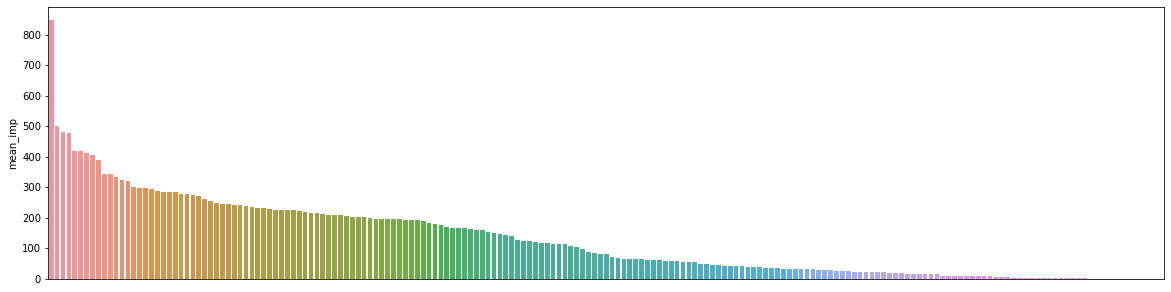

In [17]:
df_feat_imp = pd.DataFrame(index=FEATURES)
df_feat_imp["imp0"] = feature_importances[0]
df_feat_imp["imp1"] = feature_importances[1]
df_feat_imp["imp2"] = feature_importances[2]
df_feat_imp["imp3"] = feature_importances[3]
df_feat_imp["imp4"] = feature_importances[4]
df_feat_imp["mean_imp"] = df_feat_imp.mean(axis=1).values

df_feat_imp = df_feat_imp.sort_values(by="mean_imp",ascending=False)

df_feat_imp.to_csv("feat_imp.csv")

fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x=df_feat_imp.index,y=df_feat_imp["mean_imp"])
plt.xticks([])
print(df_feat_imp)

In [18]:
df_test = pd.read_parquet('./data/test.parquet')

print("convert float32 columns to float16")
for col in df_test[df_test.columns[df_test.dtypes == "float32"]]:
    df_test[col] = df_test[col].astype("float16")

print("date and time")
df_test["S_2"] = pd.to_datetime(df_test["S_2"])
df_test["days"] = (df_test["S_2"] - df_test.groupby(["customer_ID"])["S_2"].transform("min")).dt.days.astype("int16") + 1

print("grouping")
df_test = df_test.groupby(["customer_ID"]).tail(1).set_index('customer_ID')

convert float32 columns to float16
date and time
grouping


In [19]:
print("prediction")
pred=[]
for fold in range(5):
    print('FOLD:',fold)

    if len(pred)==0:
        pred = models[fold].predict_proba(df_test.drop(["S_2"], axis=1))[:, 1]
    else:
        pred += models[fold].predict_proba(df_test.drop(["S_2"], axis=1))[:, 1]

pred = pred / 5

prediction
FOLD: 0
FOLD: 1
FOLD: 2
FOLD: 3
FOLD: 4


In [20]:
subm = pd.read_csv('./data/sample_submission.csv')
subm["prediction"] = pred
subm.to_csv("submission_lightgbm.csv", index=False)